In [1]:
%matplotlib inline
import os
import glob
import cv2
import torch
import torch.nn as nn
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
from model.refinenet import rf101
from PIL import Image

In [2]:

num_classes = 21

os.environ["CUDA_VISIBLE_DEVICES"] = str(4)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

model = rf101(num_classes=num_classes, pretrained=True)
model = model.eval()
model = model.cuda()
model.load_state_dict(torch.load('checkpoints/refinenet101_voc.pth'))  


Using cuda device


<All keys matched successfully>

# Load COCO Datset

In [3]:

from pycocotools.coco import COCO
from torch.utils import data

dataDir='/home/yangqi/dataspace/COCO/'
dataType='val2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

# Initialize the COCO api for instance annotations
coco=COCO(annFile)

# Load the categories in a variable
catIDs = coco.getCatIds()
cats = coco.loadCats(catIDs)
    
cmap = np.load('utils/cmap.npy')


loading annotations into memory...
Done (t=1.01s)
creating index...
index created!


In [9]:
# 21 num classes 
CAT_LIST = [0, 5, 2, 16, 9, 44, 6, 3, 17, 62, 21, 67, 18, 19, 4,
    1, 64, 20, 63, 7, 72]  

def getClassName(classID, cats):
    """Get the class name according to classID

    Args:
        classID 
        cats 

    Returns:
        Class name
    """
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"
for i in CAT_LIST:
    print('The class name is:', getClassName(i, cats))
 



The class name is: None
The class name is: airplane
The class name is: bicycle
The class name is: bird
The class name is: boat
The class name is: bottle
The class name is: bus
The class name is: car
The class name is: cat
The class name is: chair
The class name is: cow
The class name is: dining table
The class name is: dog
The class name is: horse
The class name is: motorcycle
The class name is: person
The class name is: potted plant
The class name is: sheep
The class name is: couch
The class name is: train
The class name is: tv


Number of images containing all the classes: 85


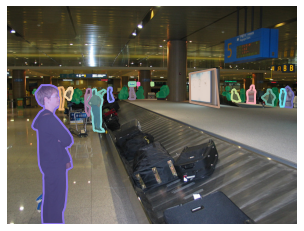

In [14]:
# Define the classes (out of the 81) which you want to see. Others will not be shown.
filterClasses = ['person','tv']

# Fetch class IDs only corresponding to the filterClasses
catIds = coco.getCatIds(catNms=filterClasses) 
# Get all images containing the above Category IDs
imgIds = coco.getImgIds(catIds=catIds)
print("Number of images containing all the classes:", len(imgIds))

# load and display a random image
img_features = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
image_file = os.path.join(dataDir , 'images/', dataType ,img_features['file_name'] )

original_image = Image.open(image_file).convert("RGB")
img = np.array(original_image)
orig_size = img.shape[:2][::-1]

annIds = coco.getAnnIds(imgIds=img_features['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
I = io.imread('{}/images/{}/{}'.format(dataDir,dataType,img_features['file_name']))/255.0

plt.axis('off')
plt.imshow(I)
coco.showAnns(anns)


#For 21 classes
all_classes = ['airplane','bicycle','bird','boat','bottle','bus','car','cat','chair','cow','dining table',
'dog','horse','motorcycle','person','potted plant','sheep','couch','train','tv']
mask = np.zeros((img_features['height'],img_features['width']))
for i in range(len(anns)):
    className = getClassName(anns[i]['category_id'], cats)
    pixel_value = all_classes.index(className)+1
    mask = np.maximum(coco.annToMask(anns[i])*pixel_value, mask)


(-0.5, 499.5, 374.5, -0.5)

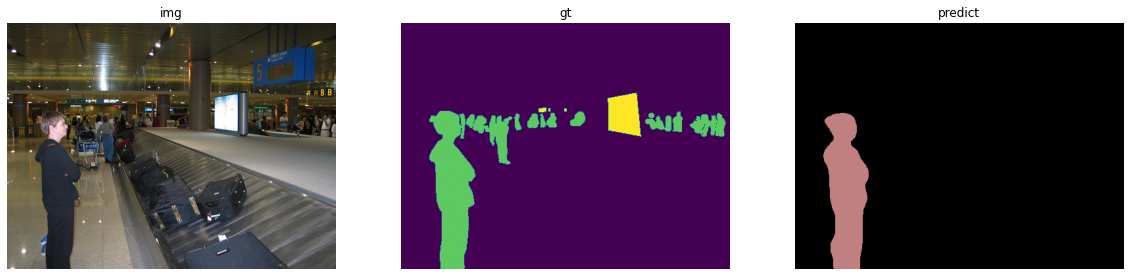

: 

In [15]:

from data.utils import custom_transforms as tr
from torchvision import transforms

CROP_SIZE = 512
transform=transforms.Compose([
        #transforms.ToPILImage(),  
        transforms.ToTensor(), #将图片转换为Tensor,归一化至[0,1]
        transforms.Resize((CROP_SIZE,CROP_SIZE))
        #transforms.Normalize(mean=cfg['DATASET']['MEAN'],std=cfg['DATASET']['STD']),
])

image = transform(img)
image = image.unsqueeze(0).cuda()

image_var = torch.autograd.Variable(image).float()
#target_var = torch.autograd.Variable(target).long()
segm = model(image_var)[0].data.cpu().numpy().transpose(1, 2, 0)

segm = cv2.resize(segm, orig_size, interpolation=cv2.INTER_CUBIC)
segm = cmap[segm.argmax(axis=2).astype(np.uint8)] # 把灰度图变成彩色图
plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.imshow(img)
plt.title('img')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(mask)
plt.title('gt')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(segm)
plt.title('predict')
plt.axis('off')